In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np

SavePlots = False

import pandas as pd

# Skip the first 9 rows
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

# Show the first 5 rows of the resulting dataframe
data.head(5)


,Date,BETA0,BETA1,BETA2,BETA3,SVEN1F01,SVEN1F04,SVEN1F09,SVENF01,SVENF02,...,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30,TAU1,TAU2
0,1961-06-14,3.917606,-1.277955,-1.949397,0.0,3.8067,3.9562,NaN,3.5492,3.8825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339218,-999.99
1,1961-06-15,3.978498,-1.257404,-2.247617,0.0,3.8694,4.0183,NaN,3.5997,3.9460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325775,-999.99
2,1961-06-16,3.984350,-1.429538,-1.885024,0.0,3.8634,4.0242,NaN,3.5957,3.9448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348817,-999.99
3,1961-06-19,4.004379,-0.723311,-3.310743,0.0,3.9196,4.0447,NaN,3.6447,3.9842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282087,-999.99
4,1961-06-20,3.985789,-0.900432,-2.844809,0.0,3.8732,4.0257,NaN,3.5845,3.9552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310316,-999.99


In [2]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter rows where Date is on or after 1985-01-02
data1 = data[data['Date'] >= '1985-01-02']

# Optional: check the result
data1.head()


# List of columns to keep always
cols_to_keep = ['Date', 'BETA0', 'BETA1', 'BETA2']

# Select columns that start with 'SVENY'
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

# Combine all columns to keep
all_keep_cols = cols_to_keep + sveny_cols

# Filter the dataframe to keep only these columns
data2 = data1[all_keep_cols]

# Check the result
data2.head()

# Drop SVENY21 to SVENY30 from data2
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

plot_data = data2

# Rename SVENY columns by stripping the prefix
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)

# Optional: convert new column names from strings like '01' to integers
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

# Check the new column names
print(plot_data.columns)



Index(['Date', 'BETA0', 'BETA1', 'BETA2', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20'],
      dtype='object')


In [3]:
import pandas as pd

df = plot_data.dropna()

df = df.drop(columns=['BETA0', 'BETA1', 'BETA2'], errors='ignore')

#Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month


#Define the cutoff dates
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

#Create the splits
train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

#Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 8234 rows
Validation set: 1750 rows
Test set: 89 rows


## Baseline/naive model

### Predicting tomorrow

In [4]:
from sklearn.metrics import mean_squared_error
import pandas as pd

val_df = val_df.copy()
val_df['naive_pred'] = val_df['2'].shift(1)
val_df = val_df.dropna(subset=['naive_pred'])

val_mse = mean_squared_error(val_df['2'], val_df['naive_pred'])
print(f"Naiv model MSE (validation): {val_mse:.4f}")

test_df = test_df.copy()
test_df['naive_pred'] = test_df['2'].shift(1)
test_df = test_df.dropna(subset=['naive_pred'])

test_mse = mean_squared_error(test_df['2'], test_df['naive_pred'])
print(f"Naiv model MSE (test): {test_mse:.4f}")


val_df = val_df.copy()
val_df['naive_pred'] = val_df['20'].shift(1)
val_df = val_df.dropna(subset=['naive_pred'])

val_mse = mean_squared_error(val_df['20'], val_df['naive_pred'])
print(f"Naiv model MSE (validation): {val_mse:.4f}")

test_df = test_df.copy()
test_df['naive_pred'] = test_df['20'].shift(1)
test_df = test_df.dropna(subset=['naive_pred'])

test_mse = mean_squared_error(test_df['20'], test_df['naive_pred'])
print(f"Naiv model MSE (test): {test_mse:.4f}")


Naiv model MSE (validation): 0.0032
Naiv model MSE (test): 0.0036
Naiv model MSE (validation): 0.0031
Naiv model MSE (test): 0.0037


### Predicting 10 days ahead

In [5]:
from sklearn.metrics import mean_squared_error
import pandas as pd


val_df_2 = val_df.copy()
val_df_2['naive_pred'] = val_df_2['2']
val_df_2['target'] = val_df_2['2'].shift(-10) 
val_df_2 = val_df_2.dropna(subset=['target'])

val_mse_2 = mean_squared_error(val_df_2['target'], val_df_2['naive_pred'])
print(f"Naiv model MSE (validation, col 2, 10-dages): {val_mse_2:.4f}")

test_df_2 = test_df.copy()
test_df_2['naive_pred'] = test_df_2['2']
test_df_2['target'] = test_df_2['2'].shift(-10)
test_df_2 = test_df_2.dropna(subset=['target'])

test_mse_2 = mean_squared_error(test_df_2['target'], test_df_2['naive_pred'])
print(f"Naiv model MSE (test, col 2, 10-dages): {test_mse_2:.4f}")



val_df_20 = val_df.copy()
val_df_20['naive_pred'] = val_df_20['20']
val_df_20['target'] = val_df_20['20'].shift(-10)
val_df_20 = val_df_20.dropna(subset=['target'])

val_mse_20 = mean_squared_error(val_df_20['target'], val_df_20['naive_pred'])
print(f"Naiv model MSE (validation, col 20, 10-dages): {val_mse_20:.4f}")

test_df_20 = test_df.copy()
test_df_20['naive_pred'] = test_df_20['20']
test_df_20['target'] = test_df_20['20'].shift(-10)
test_df_20 = test_df_20.dropna(subset=['target'])

test_mse_20 = mean_squared_error(test_df_20['target'], test_df_20['naive_pred'])
print(f"Naiv model MSE (test, col 20, 10-dages): {test_mse_20:.4f}")


Naiv model MSE (validation, col 2, 10-dages): 0.0328
Naiv model MSE (test, col 2, 10-dages): 0.0220
Naiv model MSE (validation, col 20, 10-dages): 0.0277
Naiv model MSE (test, col 20, 10-dages): 0.0264


## XGBoost - 1 day ahead

### Yield type 2

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "2"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day,
        'month': df['Date'].dt.month
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "2_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:2.49291	eval-rmse:2.06703
[1]	train-rmse:2.36918	eval-rmse:1.96659
[2]	train-rmse:2.25155	eval-rmse:1.87166
[3]	train-rmse:2.13984	eval-rmse:1.78059
[4]	train-rmse:2.03364	eval-rmse:1.69461
[5]	train-rmse:1.93275	eval-rmse:1.61305
[6]	train-rmse:1.83688	eval-rmse:1.53457
[7]	train-rmse:1.74574	eval-rmse:1.46047
[8]	train-rmse:1.65914	eval-rmse:1.39041
[9]	train-rmse:1.57685	eval-rmse:1.32413
[10]	train-rmse:1.49866	eval-rmse:1.26081
[11]	train-rmse:1.42438	eval-rmse:1.20032
[12]	train-rmse:1.35377	eval-rmse:1.14349
[13]	train-rmse:1.28670	eval-rmse:1.08964
[14]	train-rmse:1.22296	eval-rmse:1.03788
[15]	train-rmse:1.16239	eval-rmse:0.98929
[16]	train-rmse:1.10486	eval-rmse:0.94237
[17]	train-rmse:1.05017	eval-rmse:0.89859
[18]	train-rmse:0.99822	eval-rmse:0.85676
[19]	train-rmse:0.94879	eval-rmse:0.81580
[20]	train-rmse:0.90189	eval-rmse:0.77783
[21]	train-rmse:0.85728	eval-rmse:0.74108
[22]	train-rmse:0.81490	eval-rmse:0.70585
[23]	train-rmse:0.77464	eval-rmse:0.67265
[2

#### Bayesian optimization

In [ ]:
# from skopt import gp_minimize
# from skopt.space import Integer, Real
# from skopt.utils import use_named_args

# search_space = [
#     Integer(1, 500, name='n_lags'),
#     Integer(2, 15, name='max_depth'),
#     Real(0.01, 0.3, name='eta'),
#     Real(0.5, 1.0, name='subsample'),
#     Real(0.5, 1.0, name='colsample_bytree')
# ]

# @use_named_args(search_space)
# def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
#     df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

#     train_mask = df_lagged['Date'] < train_end
#     val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

#     target = f"{target_col}_target"
#     features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

#     X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
#     X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)

#     params = {
#         "objective": "reg:squarederror",
#         "max_depth": max_depth,
#         "eta": eta,
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "verbosity": 0
#     }

#     bst = xgb.train(
#         params,
#         dtrain,
#         evals=[(dval, 'eval')],
#         num_boost_round = 1000,
#         early_stopping_rounds=20,
#         verbose_eval=False
#     )

#     y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

#     val_dates = df_lagged.loc[val_mask, 'Date']
#     val_2024_mask = val_dates.dt.year == 2024

#     y_val_2024 = y_val[val_2024_mask]
#     y_pred_val_2024 = y_pred_val[val_2024_mask]

#     return mean_squared_error(y_val_2024, y_pred_val_2024)


# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=100,
#     random_state=42,
#     verbose=False
# )

# print("\nBest MSE:", result.fun)
# print("Best parameters:")
# for name, val in zip([dim.name for dim in search_space], result.x):
#     print(f"  {name}: {val}")


KeyboardInterrupt: 

In [6]:
n_lags = 1
params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 1.0,
    "verbosity": 0
}



#### Fitting on full training data

In [7]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

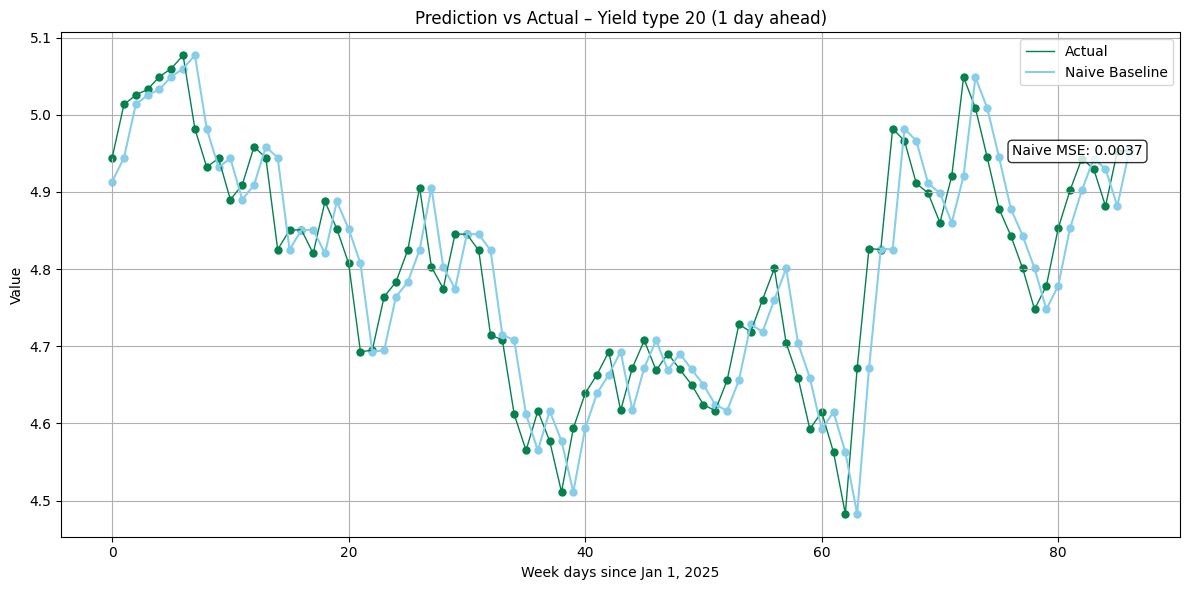

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color="#03814E", linewidth=1)
plt.scatter(x, y_test_aligned, color='#03814E', s=25)

# plt.plot(x, y_pred_aligned, label='XGBoost Predicted', color='royalblue')
# plt.scatter(x, y_pred_aligned, color='royalblue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', color='skyblue')
plt.scatter(x, naive_pred, color='skyblue', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Week days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    #f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


### Yield type 20

#### First model

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "20"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "20_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:1.86193	eval-rmse:2.78508
[1]	train-rmse:1.76963	eval-rmse:2.65936
[2]	train-rmse:1.68195	eval-rmse:2.54224
[3]	train-rmse:1.59861	eval-rmse:2.42920
[4]	train-rmse:1.51943	eval-rmse:2.32141
[5]	train-rmse:1.44414	eval-rmse:2.22278
[6]	train-rmse:1.37264	eval-rmse:2.12978
[7]	train-rmse:1.30468	eval-rmse:2.03715
[8]	train-rmse:1.24014	eval-rmse:1.95248
[9]	train-rmse:1.17878	eval-rmse:1.87008
[10]	train-rmse:1.12047	eval-rmse:1.78888
[11]	train-rmse:1.06506	eval-rmse:1.71731
[12]	train-rmse:1.01244	eval-rmse:1.64431
[13]	train-rmse:0.96242	eval-rmse:1.57369
[14]	train-rmse:0.91488	eval-rmse:1.50875
[15]	train-rmse:0.86971	eval-rmse:1.44673
[16]	train-rmse:0.82681	eval-rmse:1.38488
[17]	train-rmse:0.78603	eval-rmse:1.32648
[18]	train-rmse:0.74729	eval-rmse:1.27651
[19]	train-rmse:0.71048	eval-rmse:1.22369
[20]	train-rmse:0.67550	eval-rmse:1.17497
[21]	train-rmse:0.64228	eval-rmse:1.12728
[22]	train-rmse:0.61070	eval-rmse:1.08387
[23]	train-rmse:0.58071	eval-rmse:1.04036
[2

#### Bayesian optimization

In [43]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

search_space = [
    Integer(1, 500, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.01, 0.3, name='eta'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]

@use_named_args(search_space)
def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    train_mask = df_lagged['Date'] < train_end
    val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
    X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "eta": eta,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "verbosity": 0
    }

    bst = xgb.train(
        params,
        dtrain,
        evals=[(dval, 'eval')],
        num_boost_round = 1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

    val_dates = df_lagged.loc[val_mask, 'Date']
    val_2024_mask = val_dates.dt.year == 2024

    y_val_2024 = y_val[val_2024_mask]
    y_pred_val_2024 = y_pred_val[val_2024_mask]

    return mean_squared_error(y_val_2024, y_pred_val_2024)


result = gp_minimize(
    objective,
    search_space,
    n_calls=10,
    random_state=42,
    verbose=False
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")



Best MSE: 0.003705546439366252
Best parameters:
  n_lags: 340
  max_depth: 8
  eta: 0.013846838736361295
  subsample: 0.9711008778424265
  colsample_bytree: 0.7816441089227697


In [44]:
n_lags = 340
params = {
    "objective": "reg:squarederror",
    "max_depth": 8,
    "eta": 0.01,
    "subsample": 0.97,
    "colsample_bytree": 0.78,
    "verbosity": 0
}



#### Fitting on full training data

In [19]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

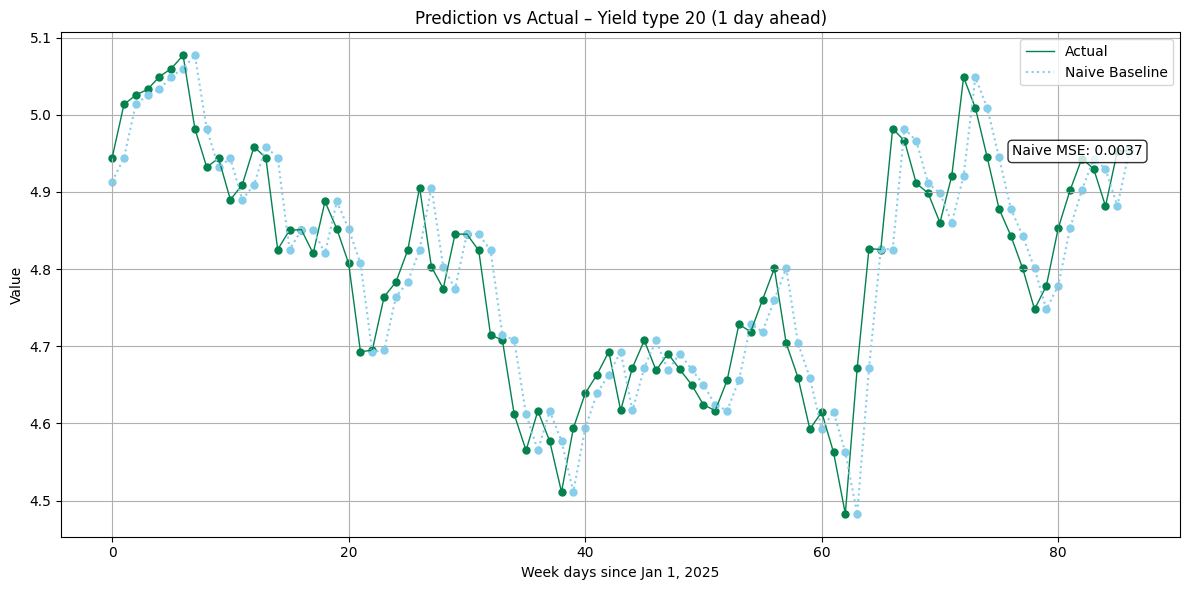

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='#03814E', linewidth=1)
plt.scatter(x, y_test_aligned, color='#03814E', s=25)

# plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
# plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='skyblue')
plt.scatter(x, naive_pred, color='skyblue', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Week days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    #f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


## XGBoost - 10 days ahead

### Yield type 2

#### First model

In [93]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "2"  
n_lags = 200
forecast_horizon = 5

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    original = df[[col]].rename(columns={col: col})

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(forecast_horizon, n_lags + forecast_horizon)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], original, target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()


df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "2_lag_10"]


[0]	train-rmse:2.51868	eval-rmse:2.13915
[1]	train-rmse:2.39386	eval-rmse:2.03492
[2]	train-rmse:2.27526	eval-rmse:1.93689
[3]	train-rmse:2.16261	eval-rmse:1.84370
[4]	train-rmse:2.05556	eval-rmse:1.75418
[5]	train-rmse:1.95387	eval-rmse:1.66988
[6]	train-rmse:1.85722	eval-rmse:1.58960
[7]	train-rmse:1.76548	eval-rmse:1.51261
[8]	train-rmse:1.67824	eval-rmse:1.43982
[9]	train-rmse:1.59537	eval-rmse:1.36995
[10]	train-rmse:1.51659	eval-rmse:1.30471
[11]	train-rmse:1.44175	eval-rmse:1.24241
[12]	train-rmse:1.37067	eval-rmse:1.18354
[13]	train-rmse:1.30318	eval-rmse:1.12731
[14]	train-rmse:1.23907	eval-rmse:1.07446
[15]	train-rmse:1.17817	eval-rmse:1.02379
[16]	train-rmse:1.12037	eval-rmse:0.97596
[17]	train-rmse:1.06545	eval-rmse:0.92977
[18]	train-rmse:1.01328	eval-rmse:0.88672
[19]	train-rmse:0.96374	eval-rmse:0.84590
[20]	train-rmse:0.91672	eval-rmse:0.80695
[21]	train-rmse:0.87206	eval-rmse:0.77025
[22]	train-rmse:0.82967	eval-rmse:0.73464
[23]	train-rmse:0.78943	eval-rmse:0.70158
[2

In [90]:
print(df_lagged[[target_col, f'{target_col}_target'] + [f'{target_col}_lag_{i}' for i in range(forecast_horizon, 15)]].head(11))

           2  2_target  2_lag_5  2_lag_6  2_lag_7  2_lag_8  2_lag_9  2_lag_10  \
6668  6.2606    6.1541   6.2606   6.3105   6.3613   6.3885   6.3178    6.2718   
6669  6.2539    6.1722   6.2539   6.2606   6.3105   6.3613   6.3885    6.3178   
6670  6.2199    6.1795   6.2199   6.2539   6.2606   6.3105   6.3613    6.3885   
6671  6.1702    6.1707   6.1702   6.2199   6.2539   6.2606   6.3105    6.3613   
6672  6.1440    6.1507   6.1440   6.1702   6.2199   6.2539   6.2606    6.3105   
6673  6.1541    6.1120   6.1541   6.1440   6.1702   6.2199   6.2539    6.2606   
6674  6.1722    6.1244   6.1722   6.1541   6.1440   6.1702   6.2199    6.2539   
6675  6.1795    6.1237   6.1795   6.1722   6.1541   6.1440   6.1702    6.2199   
6676  6.1707    6.1300   6.1707   6.1795   6.1722   6.1541   6.1440    6.1702   
6677  6.1507    6.1688   6.1507   6.1707   6.1795   6.1722   6.1541    6.1440   
6679  6.1120    6.1757   6.1120   6.1507   6.1707   6.1795   6.1722    6.1541   

      2_lag_11  2_lag_12  2

#### Bayesian optimization

In [ ]:
# from skopt import gp_minimize
# from skopt.space import Integer, Real
# from skopt.utils import use_named_args

# search_space = [
#     Integer(1, 500, name='n_lags'),
#     Integer(2, 15, name='max_depth'),
#     Real(0.01, 0.3, name='eta'),
#     Real(0.5, 1.0, name='subsample'),
#     Real(0.5, 1.0, name='colsample_bytree')
# ]

# @use_named_args(search_space)
# def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
#     df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

#     train_mask = df_lagged['Date'] < train_end
#     val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

#     target = f"{target_col}_target"
#     features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

#     X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
#     X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)

#     params = {
#         "objective": "reg:squarederror",
#         "max_depth": max_depth,
#         "eta": eta,
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "verbosity": 0
#     }

#     bst = xgb.train(
#         params,
#         dtrain,
#         evals=[(dval, 'eval')],
#         num_boost_round = 1000,
#         early_stopping_rounds=20,
#         verbose_eval=False
#     )

#     y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

#     val_dates = df_lagged.loc[val_mask, 'Date']
#     val_2024_mask = val_dates.dt.year == 2024

#     y_val_2024 = y_val[val_2024_mask]
#     y_pred_val_2024 = y_pred_val[val_2024_mask]

#     return mean_squared_error(y_val_2024, y_pred_val_2024)


# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=50,
#     random_state=42,
#     verbose=False
# )

# print("\nBest MSE:", result.fun)
# print("Best parameters:")
# for name, val in zip([dim.name for dim in search_space], result.x):
#     print(f"  {name}: {val}")



Best MSE: 0.03582687684120115
Best parameters:
  n_lags: 1
  max_depth: 3
  eta: 0.05284357244830327
  subsample: 0.5169682662061728
  colsample_bytree: 1.0


In [85]:
n_lags = 500
params = {
    "objective": "reg:squarederror",
    "max_depth": 3,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "verbosity": 0
}



#### Fitting on full training data

In [94]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

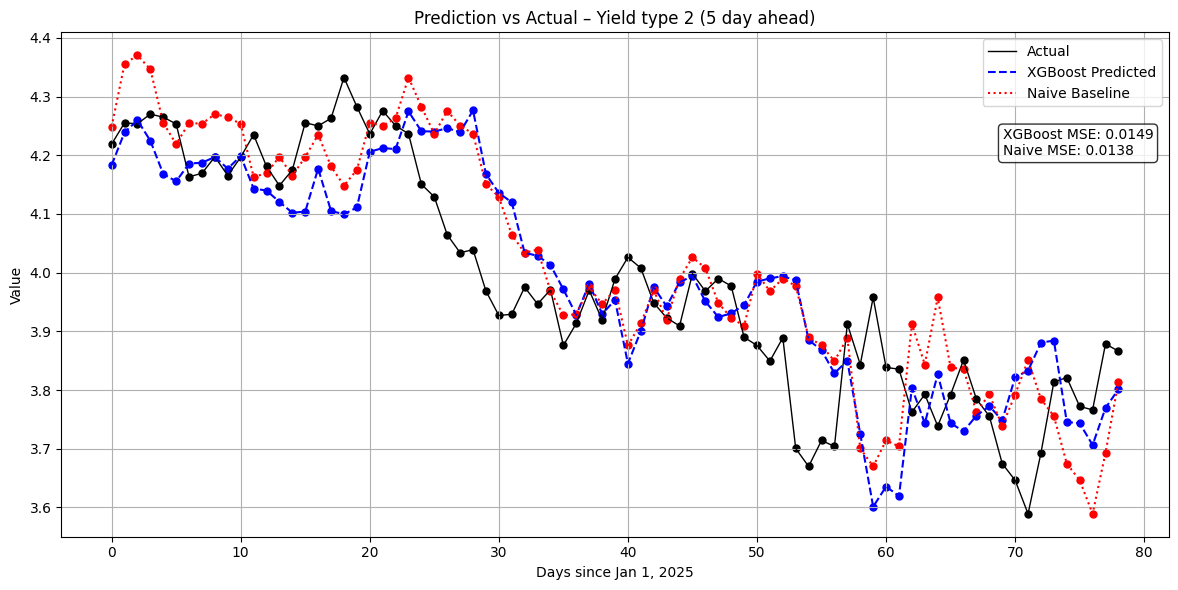

In [95]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_aligned, color='black', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')
plt.scatter(x, naive_pred, color='red', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


### Yield type 20

#### First model

In [63]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "20"  
n_lags = 500
forecast_horizon = 10

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "20_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:1.86329	eval-rmse:2.77513
[1]	train-rmse:1.77092	eval-rmse:2.65022
[2]	train-rmse:1.68317	eval-rmse:2.53347
[3]	train-rmse:1.59976	eval-rmse:2.42509
[4]	train-rmse:1.52054	eval-rmse:2.31894
[5]	train-rmse:1.44523	eval-rmse:2.21669
[6]	train-rmse:1.37365	eval-rmse:2.12413
[7]	train-rmse:1.30567	eval-rmse:2.03169
[8]	train-rmse:1.24103	eval-rmse:1.94234
[9]	train-rmse:1.17962	eval-rmse:1.86252
[10]	train-rmse:1.12127	eval-rmse:1.78239
[11]	train-rmse:1.06582	eval-rmse:1.70731
[12]	train-rmse:1.01313	eval-rmse:1.63358
[13]	train-rmse:0.96308	eval-rmse:1.56567
[14]	train-rmse:0.91552	eval-rmse:1.49812
[15]	train-rmse:0.87033	eval-rmse:1.43398
[16]	train-rmse:0.82738	eval-rmse:1.37634
[17]	train-rmse:0.78658	eval-rmse:1.31835
[18]	train-rmse:0.74780	eval-rmse:1.26468
[19]	train-rmse:0.71098	eval-rmse:1.21234
[20]	train-rmse:0.67600	eval-rmse:1.16491
[21]	train-rmse:0.64273	eval-rmse:1.12172
[22]	train-rmse:0.61114	eval-rmse:1.08080
[23]	train-rmse:0.58112	eval-rmse:1.03794
[2

#### Bayesian optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

search_space = [
    Integer(1, 500, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.01, 0.3, name='eta'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]

@use_named_args(search_space)
def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    train_mask = df_lagged['Date'] < train_end
    val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
    X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "eta": eta,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "verbosity": 0
    }

    bst = xgb.train(
        params,
        dtrain,
        evals=[(dval, 'eval')],
        num_boost_round = 1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

    val_dates = df_lagged.loc[val_mask, 'Date']
    val_2024_mask = val_dates.dt.year == 2024

    y_val_2024 = y_val[val_2024_mask]
    y_pred_val_2024 = y_pred_val[val_2024_mask]

    return mean_squared_error(y_val_2024, y_pred_val_2024)


result = gp_minimize(
    objective,
    search_space,
    n_calls=100,
    random_state=42,
    verbose=False
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")


In [ ]:
n_lags = 398
params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.23,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "verbosity": 0
}



#### Fitting on full training data

In [64]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

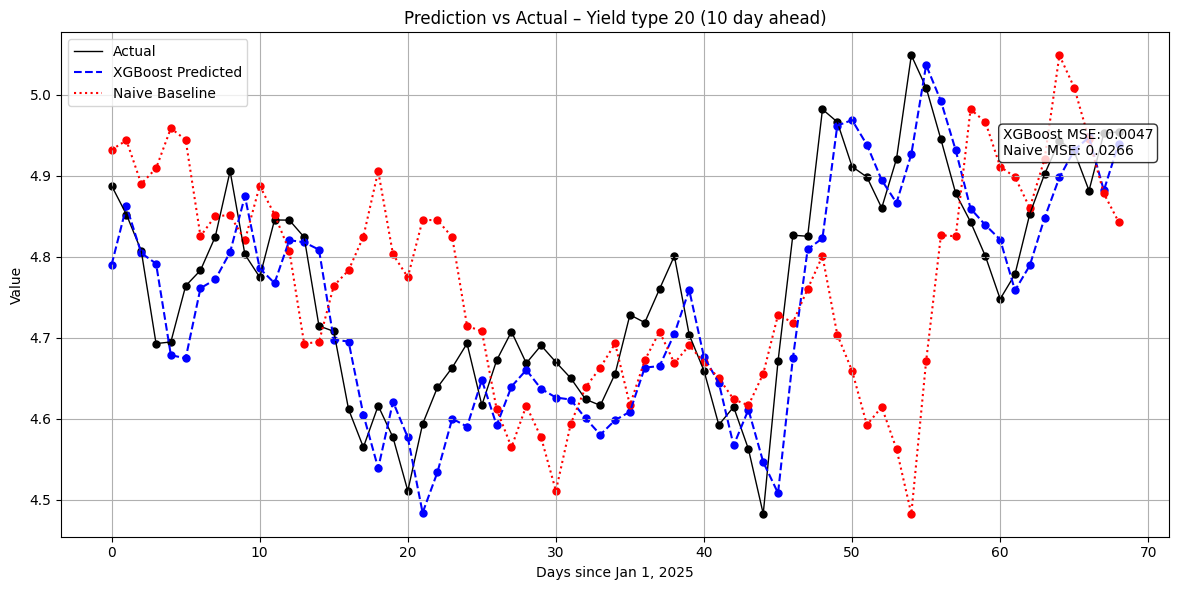

In [65]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_aligned, color='black', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')
plt.scatter(x, naive_pred, color='red', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


## XGBoost - 1 day ahead

### Yield type 2

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "2"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "2_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:2.49291	eval-rmse:2.06703
[1]	train-rmse:2.36918	eval-rmse:1.96659
[2]	train-rmse:2.25155	eval-rmse:1.87166
[3]	train-rmse:2.13984	eval-rmse:1.78059
[4]	train-rmse:2.03364	eval-rmse:1.69461
[5]	train-rmse:1.93275	eval-rmse:1.61305
[6]	train-rmse:1.83688	eval-rmse:1.53457
[7]	train-rmse:1.74574	eval-rmse:1.46047
[8]	train-rmse:1.65914	eval-rmse:1.39041
[9]	train-rmse:1.57685	eval-rmse:1.32413
[10]	train-rmse:1.49866	eval-rmse:1.26081
[11]	train-rmse:1.42438	eval-rmse:1.20032
[12]	train-rmse:1.35377	eval-rmse:1.14349
[13]	train-rmse:1.28670	eval-rmse:1.08964
[14]	train-rmse:1.22296	eval-rmse:1.03788
[15]	train-rmse:1.16239	eval-rmse:0.98929
[16]	train-rmse:1.10486	eval-rmse:0.94237
[17]	train-rmse:1.05017	eval-rmse:0.89859
[18]	train-rmse:0.99822	eval-rmse:0.85676
[19]	train-rmse:0.94879	eval-rmse:0.81580
[20]	train-rmse:0.90189	eval-rmse:0.77783
[21]	train-rmse:0.85728	eval-rmse:0.74108
[22]	train-rmse:0.81490	eval-rmse:0.70585
[23]	train-rmse:0.77464	eval-rmse:0.67265
[2

#### Bayesian optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

search_space = [
    Integer(1, 500, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.01, 0.3, name='eta'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]

@use_named_args(search_space)
def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    train_mask = df_lagged['Date'] < train_end
    val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
    X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "eta": eta,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "verbosity": 0
    }

    bst = xgb.train(
        params,
        dtrain,
        evals=[(dval, 'eval')],
        num_boost_round = 1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

    val_dates = df_lagged.loc[val_mask, 'Date']
    val_2024_mask = val_dates.dt.year == 2024

    y_val_2024 = y_val[val_2024_mask]
    y_pred_val_2024 = y_pred_val[val_2024_mask]

    return mean_squared_error(y_val_2024, y_pred_val_2024)


result = gp_minimize(
    objective,
    search_space,
    n_calls=100,
    random_state=42,
    verbose=False
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")



Best MSE: 0.003497949368101324
Best parameters:
  n_lags: 1
  max_depth: 5
  eta: 0.01
  subsample: 0.5
  colsample_bytree: 1.0


In [ ]:
n_lags = 1
params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 1.0,
    "verbosity": 0
}



#### Fitting on full training data

In [ ]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

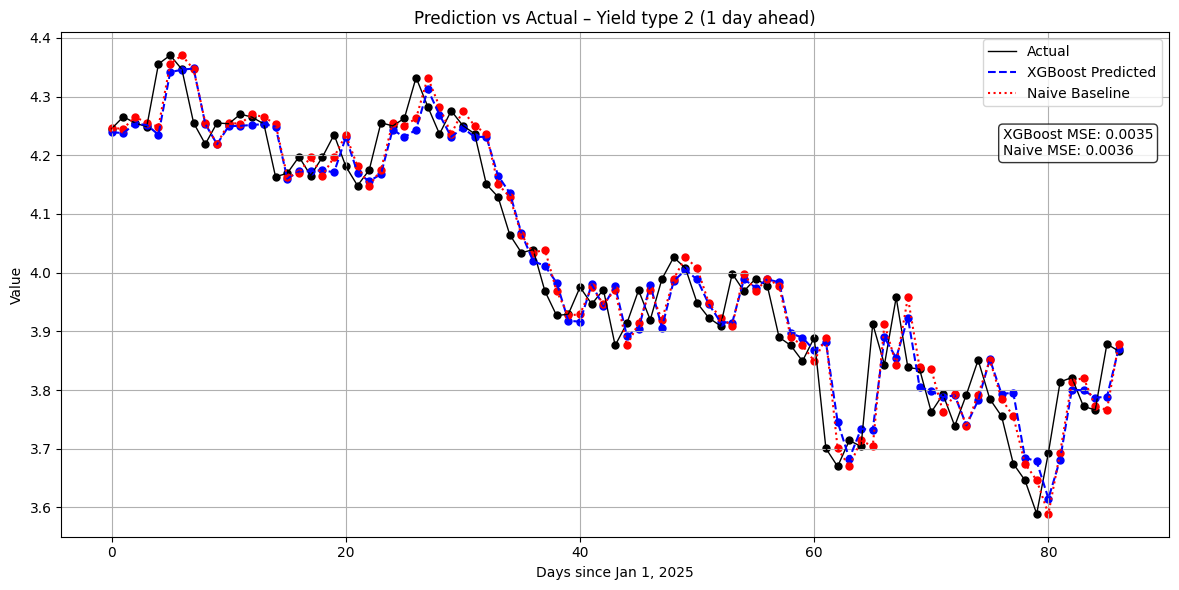

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_aligned, color='black', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')
plt.scatter(x, naive_pred, color='red', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


### Yield type 20

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "20"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "20_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:1.86193	eval-rmse:2.78508
[1]	train-rmse:1.76963	eval-rmse:2.65936
[2]	train-rmse:1.68195	eval-rmse:2.54224
[3]	train-rmse:1.59861	eval-rmse:2.42920
[4]	train-rmse:1.51943	eval-rmse:2.32141
[5]	train-rmse:1.44414	eval-rmse:2.22278
[6]	train-rmse:1.37264	eval-rmse:2.12978
[7]	train-rmse:1.30468	eval-rmse:2.03715
[8]	train-rmse:1.24014	eval-rmse:1.95248
[9]	train-rmse:1.17878	eval-rmse:1.87008
[10]	train-rmse:1.12047	eval-rmse:1.78888
[11]	train-rmse:1.06506	eval-rmse:1.71731
[12]	train-rmse:1.01244	eval-rmse:1.64431
[13]	train-rmse:0.96242	eval-rmse:1.57369
[14]	train-rmse:0.91488	eval-rmse:1.50875
[15]	train-rmse:0.86971	eval-rmse:1.44673
[16]	train-rmse:0.82681	eval-rmse:1.38488
[17]	train-rmse:0.78603	eval-rmse:1.32648
[18]	train-rmse:0.74729	eval-rmse:1.27651
[19]	train-rmse:0.71048	eval-rmse:1.22369
[20]	train-rmse:0.67550	eval-rmse:1.17497
[21]	train-rmse:0.64228	eval-rmse:1.12728
[22]	train-rmse:0.61070	eval-rmse:1.08387
[23]	train-rmse:0.58071	eval-rmse:1.04036
[2

#### Bayesian optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

search_space = [
    Integer(1, 500, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.01, 0.3, name='eta'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]

@use_named_args(search_space)
def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    train_mask = df_lagged['Date'] < train_end
    val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
    X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "eta": eta,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "verbosity": 0
    }

    bst = xgb.train(
        params,
        dtrain,
        evals=[(dval, 'eval')],
        num_boost_round = 1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

    val_dates = df_lagged.loc[val_mask, 'Date']
    val_2024_mask = val_dates.dt.year == 2024

    y_val_2024 = y_val[val_2024_mask]
    y_pred_val_2024 = y_pred_val[val_2024_mask]

    return mean_squared_error(y_val_2024, y_pred_val_2024)


result = gp_minimize(
    objective,
    search_space,
    n_calls=10,
    random_state=42,
    verbose=False
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")



Best MSE: 0.003705546439366252
Best parameters:
  n_lags: 340
  max_depth: 8
  eta: 0.013846838736361295
  subsample: 0.9711008778424265
  colsample_bytree: 0.7816441089227697


In [ ]:
n_lags = 340
params = {
    "objective": "reg:squarederror",
    "max_depth": 8,
    "eta": 0.01,
    "subsample": 0.97,
    "colsample_bytree": 0.78,
    "verbosity": 0
}



#### Fitting on full training data

In [ ]:
train_val_mask = train_mask | val_mask

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)

bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

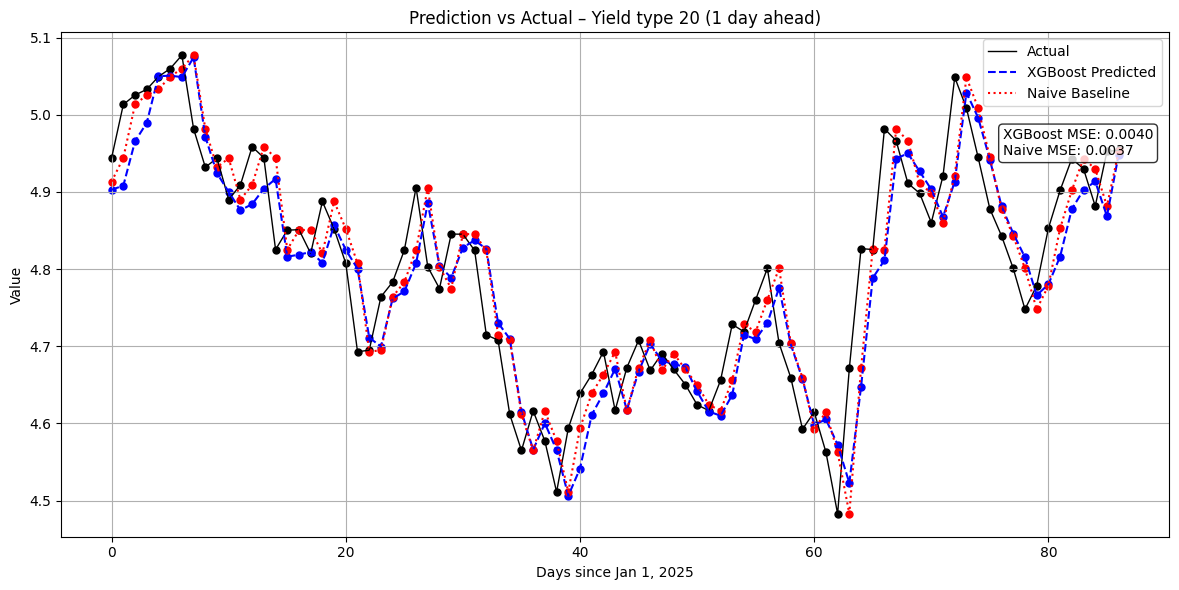

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_aligned, color='black', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')
plt.scatter(x, naive_pred, color='red', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


# GRU

In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Dataforberedelse ---

df = plot_data.dropna()

df = df.drop(columns=['BETA0', 'BETA1', 'BETA2'], errors='ignore')

# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month

# Definér cutoff-datoer
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

# Split data
train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")



Train set: 8234 rows
Validation set: 1750 rows
Test set: 89 rows


In [94]:
target_col = '2'
features = [col for col in df.columns if col not in ['Date', target_col]]

def create_sliding_windows(df, target_col, seq_length=30):
    feature_cols = [col for col in df.columns if col not in ['Date', target_col]]
    data = df[feature_cols].values
    targets = df[target_col].values
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        seq_x = data[i:i+seq_length]
        seq_y = targets[i+seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)

# Skab testvinduer
X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

# --- Skalering ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



Train shape: (8204, 30, 21)
Val shape: (1720, 30, 21)
Test shape: (89, 30, 21)


In [100]:

gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(tf.keras.layers.Dropout(0.5))
gru_model.add(tf.keras.layers.GRU(64))
gru_model.add(tf.keras.layers.Dense(1))
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')



optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=optimizer, loss='mse')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# def scheduler(epoch, lr):
#     decay_rate = 0.9
#     decay_step = 5
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)




Epoch 1/20


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 - 4s - 31ms/step - loss: 0.0400 - val_loss: 0.0053
Epoch 2/20
129/129 - 3s - 21ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 3/20
129/129 - 3s - 23ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/20
129/129 - 3s - 22ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 5/20
129/129 - 3s - 22ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 6/20
129/129 - 3s - 23ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 7/20
129/129 - 3s - 22ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/20
129/129 - 3s - 21ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 9/20
129/129 - 3s - 21ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/20
129/129 - 3s - 21ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 11/20
129/129 - 3s - 21ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/20
129/129 - 3s - 20ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 13/20
129/129 - 3s - 21ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 14/20
129/129 - 3s - 21ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 15/20
129/129 - 3s -

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Test MSE for GRU (original scale): 0.0078


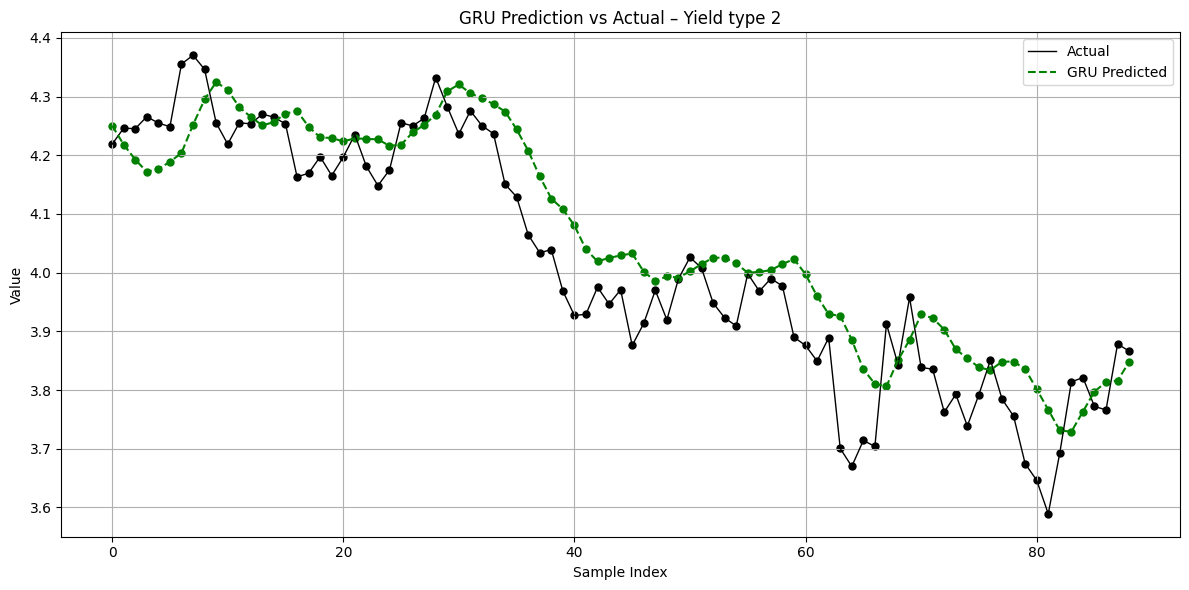

In [95]:

# --- Evaluering og plotting ---

# Predict på test data (skaleret)
y_pred_scaled = gru_model.predict(X_test).flatten()

# Inverse transform til original skala
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# Lav serier med indeks fra test_df (forkortet til y_test_inv længde)
y_test_series = pd.Series(y_test_inv, index=test_df.index[:len(y_test_inv)])
y_pred_series = pd.Series(y_pred_inv, index=y_test_series.index[:len(y_pred_inv)])

common_index = y_test_series.index.intersection(y_pred_series.index)

mse_gru = mean_squared_error(y_test_series.loc[common_index], y_pred_series.loc[common_index])
print(f"Test MSE for GRU (original scale): {mse_gru:.4f}")

# Plot actual vs predicted
x = np.arange(len(common_index))

plt.figure(figsize=(12, 6))
plt.plot(x, y_test_series.loc[common_index], label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_series.loc[common_index], color='black', s=25)

plt.plot(x, y_pred_series.loc[common_index], label='GRU Predicted', linestyle='--', color='green')
plt.scatter(x, y_pred_series.loc[common_index], color='green', s=25)

plt.title(f'GRU Prediction vs Actual – Yield type {target_col}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [161]:
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)

# Skab testvinduer
X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

# --- Skalering ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



# Sammenlæg train og val (stadig i skaleret form)
X_final_train = np.concatenate([X_train, X_val], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)

# Definér og compilér en ny model
final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(X_final_train.shape[1], X_final_train.shape[2])))
final_model.add(tf.keras.layers.Dropout(0.2))
final_model.add(tf.keras.layers.GRU(64, return_sequences=False))  # <- now it's okay
final_model.add(LeakyReLU(alpha=0.1))
final_model.add(tf.keras.layers.Dense(1))


final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Træn på hele (train + val) datasæt
history_final = final_model.fit(
    X_final_train, y_final_train,
    epochs=20,
    batch_size=32,
    verbose=2
)

# Predict på test
y_pred_final_scaled = final_model.predict(X_test).flatten()

# Inverse transform af både prediction og faktisk test target
y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluerings-MSE i uskaleret rum
mse_final = mean_squared_error(y_test_unscaled, y_pred_final)
print(f"Final MSE on Test (uskaleret): {mse_final:.4f}")


Train shape: (8204, 30, 21)
Val shape: (1720, 30, 21)
Test shape: (89, 30, 21)
Epoch 1/20


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


311/311 - 5s - 16ms/step - loss: 0.0241
Epoch 2/20
311/311 - 4s - 13ms/step - loss: 0.0029
Epoch 3/20
311/311 - 4s - 13ms/step - loss: 0.0025
Epoch 4/20
311/311 - 4s - 13ms/step - loss: 0.0021
Epoch 5/20
311/311 - 4s - 13ms/step - loss: 0.0021
Epoch 6/20
311/311 - 4s - 13ms/step - loss: 0.0018
Epoch 7/20
311/311 - 4s - 13ms/step - loss: 0.0017
Epoch 8/20
311/311 - 4s - 13ms/step - loss: 0.0018
Epoch 9/20
311/311 - 4s - 13ms/step - loss: 0.0017
Epoch 10/20
311/311 - 4s - 13ms/step - loss: 0.0014
Epoch 11/20
311/311 - 4s - 13ms/step - loss: 0.0014
Epoch 12/20
311/311 - 4s - 14ms/step - loss: 0.0015
Epoch 13/20
311/311 - 4s - 14ms/step - loss: 0.0014
Epoch 14/20
311/311 - 4s - 13ms/step - loss: 0.0015
Epoch 15/20
311/311 - 4s - 13ms/step - loss: 0.0013
Epoch 16/20
311/311 - 4s - 14ms/step - loss: 0.0013
Epoch 17/20
311/311 - 4s - 13ms/step - loss: 0.0013
Epoch 18/20
311/311 - 4s - 14ms/step - loss: 0.0012
Epoch 19/20
311/311 - 4s - 14ms/step - loss: 0.0013
Epoch 20/20
311/311 - 4s - 14ms/

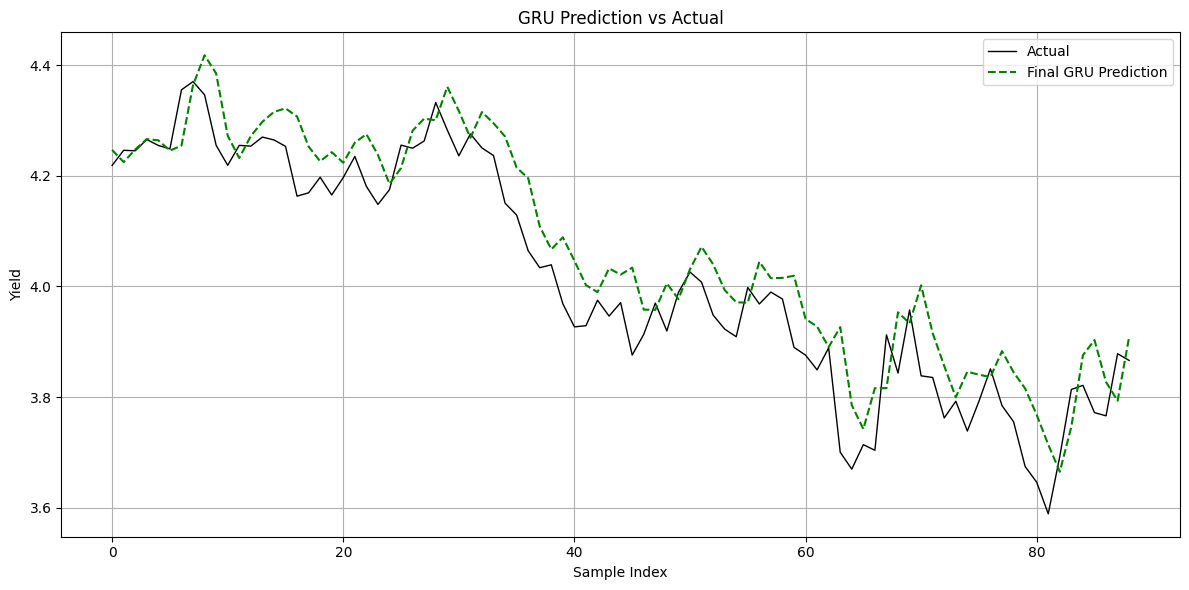

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', color='black', linewidth=1)
plt.plot(y_pred_final, label='Final GRU Prediction', linestyle='--', color='green')
plt.title('GRU Prediction vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


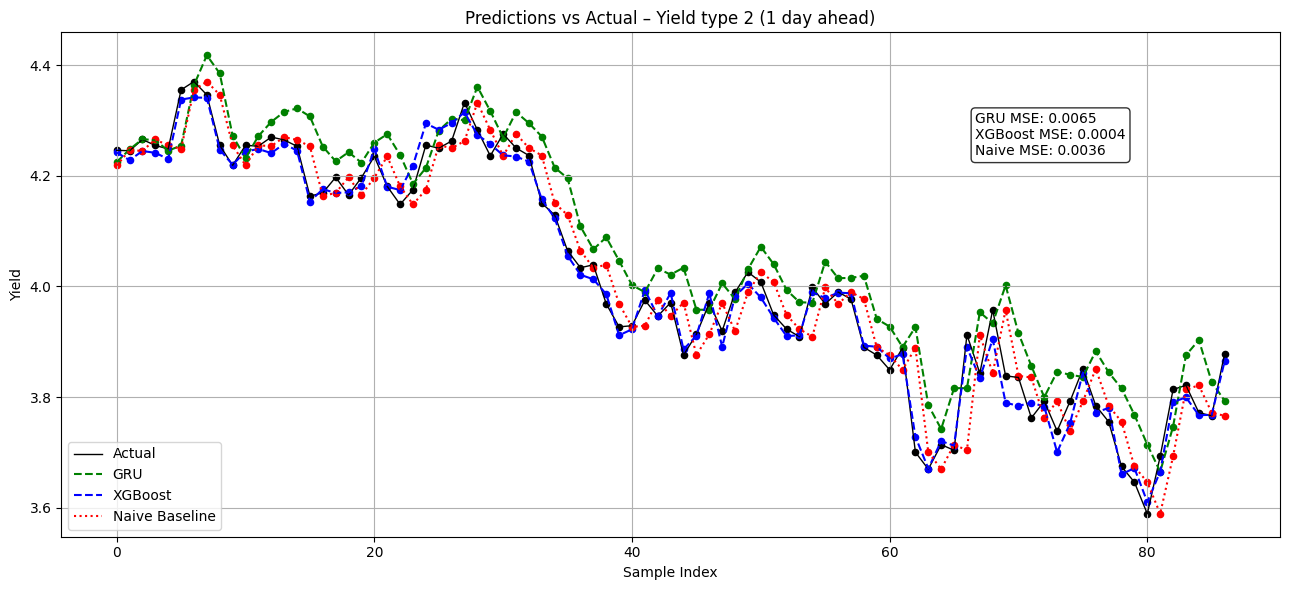

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Naiv baseline ---
naive_pred_series = pd.Series(y_test_unscaled, index=test_df.index[:len(y_test_unscaled)])
naive_pred = naive_pred_series.shift(forecast_horizon).dropna()

# --- GRU Prediction som Series ---
gru_pred_series = pd.Series(y_pred_final, index=test_df.index[:len(y_pred_final)])
actual_series = pd.Series(y_test_unscaled, index=test_df.index[:len(y_test_unscaled)])

# --- XGBoost prediction (skal defineres af dig) ---
# Sørg for, at 'y_pred_full' er Series med samme index som y_test
# Eksempel (hvis du allerede har xgboost-predictions):
# y_pred_full = pd.Series(bst_final.predict(dtest), index=test_df.index[:len(dtest)])
# (Du skal erstatte det ovenfor med dit eget)

# --- Find fælles index ---
common_index = actual_series.index.intersection(naive_pred.index)
common_index = common_index.intersection(gru_pred_series.index)
common_index = common_index.intersection(y_pred_full.index)

# --- Justér alle serier til samme tidsvindue ---
actual = actual_series.loc[common_index]
gru_pred = gru_pred_series.loc[common_index]
naive_pred = naive_pred.loc[common_index]
xgb_pred = y_pred_full.loc[common_index]

# --- MSE-beregning ---
mse_gru = mean_squared_error(actual, gru_pred)
mse_xgb = mean_squared_error(actual, xgb_pred)
mse_naive = mean_squared_error(actual, naive_pred)

# --- Plot ---
x = np.arange(len(actual))
plt.figure(figsize=(13, 6))

plt.plot(x, actual, label='Actual', color='black', linewidth=1)
plt.plot(x, gru_pred, label='GRU', linestyle='--', color='green')
plt.plot(x, xgb_pred, label='XGBoost', linestyle='--', color='blue')
plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')

plt.scatter(x, actual, color='black', s=20)
plt.scatter(x, gru_pred, color='green', s=20)
plt.scatter(x, xgb_pred, color='blue', s=20)
plt.scatter(x, naive_pred, color='red', s=20)

plt.title(f'Predictions vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Sample Index')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)

# Tekstboks med MSE
textstr = '\n'.join((
    f'GRU MSE: {mse_gru:.4f}',
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.75, 0.75, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


# VAE

## Defining the VAE

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data3 = data2[data2["Date"] >= "1991-01-01"].copy()
data_clean = data3.dropna().drop(columns=["Date"]).copy()
data_features = data_clean.drop(columns=['BETA0', 'BETA1', 'BETA2'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], latent_dim=2):
        super().__init__()
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mean = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

        decoder_layers = []
        hidden_dims_rev = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_rev:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mean(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def loss_fn(x, x_hat, mu, logvar, beta=0.1):
    recon = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return recon + beta * kl


epochs = 100
batch_size = 32
input_dim = X_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tscv = TimeSeriesSplit(n_splits=5)
val_losses_per_epoch = []
train_losses_per_epoch = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tensor)):
    print(f"Fold {fold+1}")

    X_train = X_tensor[train_idx]
    X_val = X_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val), batch_size=batch_size)

    model = VAE(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    fold_train_losses = []
    fold_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(x)
            loss = loss_fn(x, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        fold_train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                x_hat, mu, logvar = model(x)
                val_loss = loss_fn(x, x_hat, mu, logvar)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        fold_val_losses.append(avg_val_loss)

    train_losses_per_epoch.append(fold_train_losses)
    val_losses_per_epoch.append(fold_val_losses)


val_losses_per_epoch = np.array(val_losses_per_epoch)
mean_val_loss = val_losses_per_epoch.mean(axis=0)
best_epoch = np.argmin(mean_val_loss)

print(f"\n📉 Best epoch: {best_epoch}")
print(f"📊 Mean validation loss first 20 epochs:\n{mean_val_loss[:20]}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

📉 Best epoch: 75
📊 Mean validation loss first 20 epochs:
[222.92167653 124.46444936 113.04994059  90.58807678  77.17075839
  70.87658815  64.26101762  58.33090933  51.42968878  59.36873995
  46.64953835  56.71459277  44.3621521   50.44065883  42.54343426
  46.95652008  43.62827035  45.84372749  44.8066456   39.9906877 ]


In [41]:
start_train_loss = train_losses_per_epoch[0][0]
end_train_loss = train_losses_per_epoch[0][-1]

start_val_loss = val_losses_per_epoch[0][0]
end_val_loss = val_losses_per_epoch[0][-1]

print(f"Train loss start: {start_train_loss:.3f}, end: {end_train_loss:.3f}")
print(f"Val loss start: {start_val_loss:.3f}, end: {end_val_loss:.3f}")

best_val_loss = mean_val_loss[best_epoch]
print(f"Best validation loss at epoch {best_epoch}: {best_val_loss:.3f}")


Train loss start: 653.768, end: 18.002
Val loss start: 158.547, end: 35.552
Best validation loss at epoch 75: 34.944


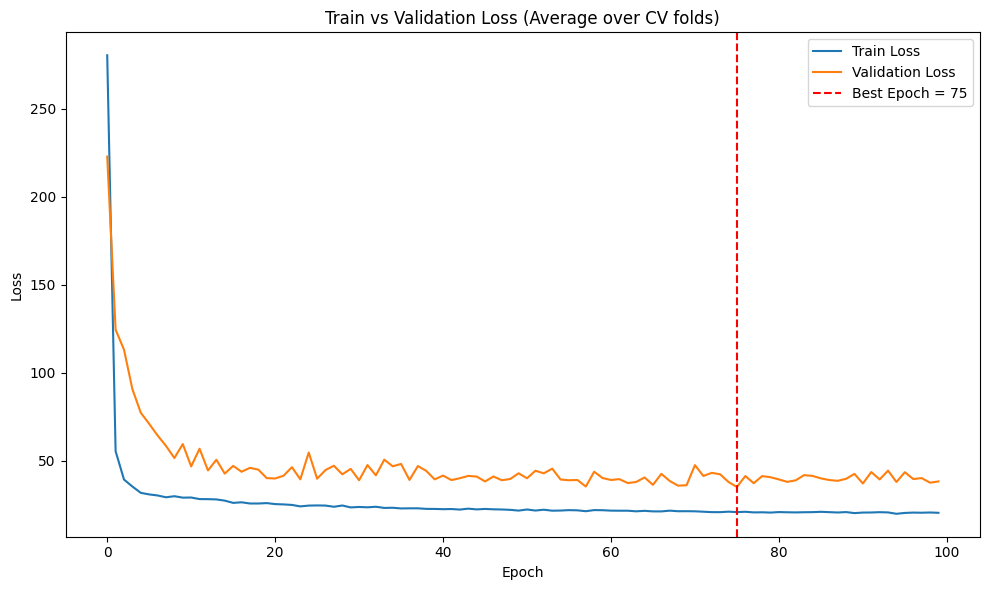

In [43]:
train_losses_per_epoch = np.array(train_losses_per_epoch)
val_losses_per_epoch = np.array(val_losses_per_epoch)

mean_train_loss = train_losses_per_epoch.mean(axis=0)
mean_val_loss = val_losses_per_epoch.mean(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_train_loss, label="Train Loss")
plt.plot(mean_val_loss, label="Validation Loss")
plt.axvline(best_epoch, color='red', linestyle='--', label=f"Best Epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Average over CV folds)")
plt.legend()
plt.tight_layout()
plt.show()


## Comparison - reconstructed vs actual

In [28]:
final_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(best_epoch):
    model.train()
    for batch in final_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()


model.eval()
with torch.no_grad():
    X_recon, _, _ = model(X_tensor.to(device))


rec_err = ((X_tensor - X_recon.cpu())**2).mean(dim=1).numpy()


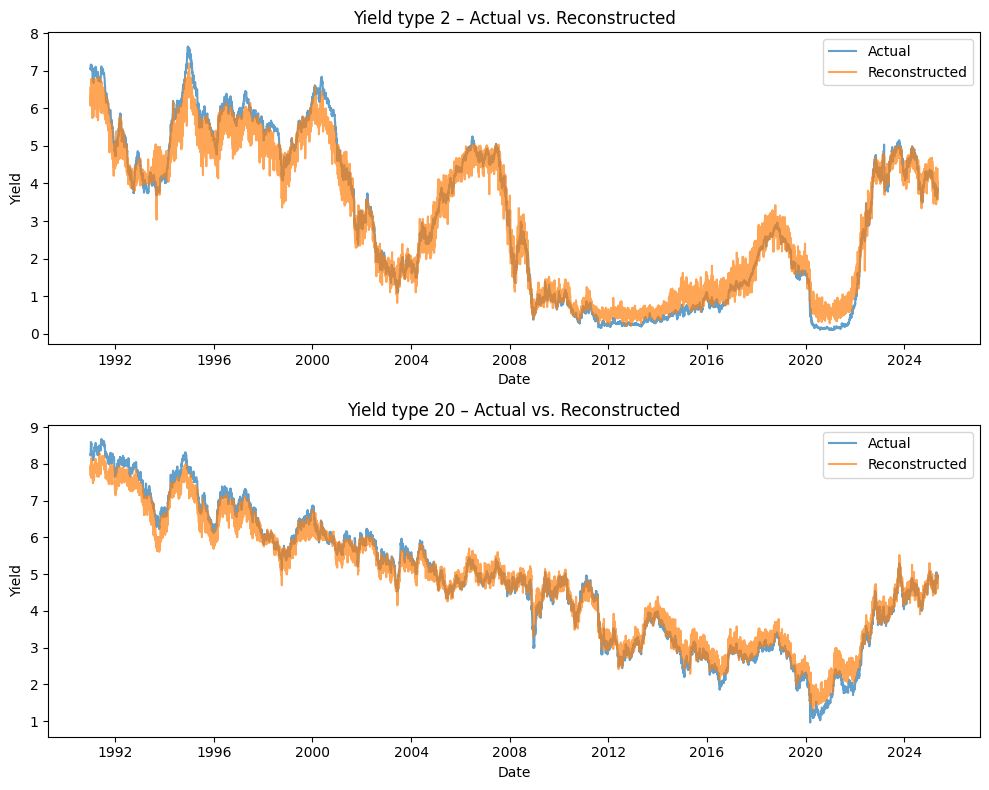

In [29]:
data_clean = data3.dropna().copy()
dates = data_clean["Date"].reset_index(drop=True)


data_features = data_clean.drop(columns=["Date", 'BETA0', 'BETA1', 'BETA2']) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


X_reconstructed_original = scaler.inverse_transform(X_recon.cpu().numpy())
reconstructed_df = pd.DataFrame(X_reconstructed_original, columns=data_features.columns)
original_df = pd.DataFrame(scaler.inverse_transform(X_tensor.numpy()), columns=data_features.columns)


original_df["Date"] = dates
reconstructed_df["Date"] = dates


col_idx_1 = 1 
col_idx_2 = 19
col_name_1 = data_features.columns[col_idx_1]
col_name_2 = data_features.columns[col_idx_2]


plt.figure(figsize=(10, 8)) 

plt.subplot(2, 1, 1)
plt.plot(original_df["Date"], original_df[col_name_1], label="Actual", alpha=0.7)
plt.plot(reconstructed_df["Date"], reconstructed_df[col_name_1], label="Reconstructed", alpha=0.7)
plt.title(f"Yield type {col_name_1} – Actual vs. Reconstructed")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(original_df["Date"], original_df[col_name_2], label="Actual", alpha=0.7)
plt.plot(reconstructed_df["Date"], reconstructed_df[col_name_2], label="Reconstructed", alpha=0.7)
plt.title(f"Yield type {col_name_2} – Actual vs. Reconstructed")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()

plt.tight_layout()
plt.show()



## Anomalies

In [31]:

fed_df = pd.read_csv("FED_interest.csv", parse_dates=["Date"])

fed_df["Rate Change (bps)"] = pd.to_numeric(fed_df["Rate Change (bps)"], errors="coerce")

fed_change_dates = fed_df.loc[fed_df["Rate Change (bps)"] != 0, "Date"]


def overlap_score(result_df, fed_dates, window_days=3):
    anomaly_dates = result_df[result_df["anomaly"]]["Date"]
    score = 0
    for fed_date in fed_dates:
        window_start = fed_date - pd.Timedelta(days=window_days)
        window_end = fed_date + pd.Timedelta(days=window_days)
        if any((anomaly_dates >= window_start) & (anomaly_dates <= window_end)):
            score += 1
    return score



🎯 Overlap score: 6


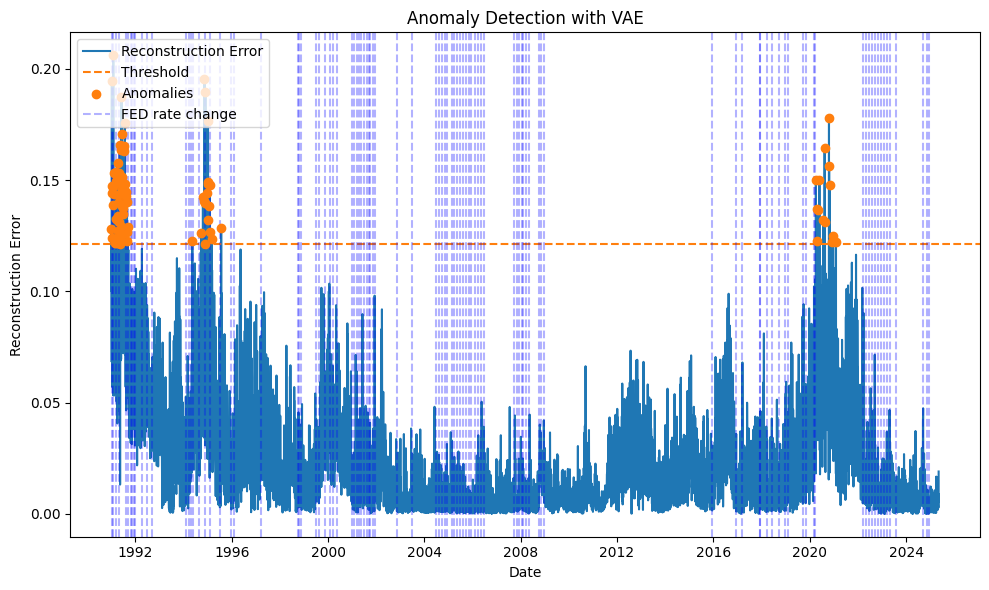

In [ ]:
threshold = np.percentile(rec_err, 99)
anomalies = rec_err > threshold


result_df = pd.DataFrame({
    "Date": data2.loc[data3.dropna().index, "Date"].reset_index(drop=True),
    "reconstruction_error": rec_err,
    "anomaly": anomalies
})



score = overlap_score(result_df, fed_change_dates, window_days=3)
print(f"\n🎯 Overlap score: {score}")

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
orange_color = default_colors[1] 

plt.figure(figsize=(10,6))
plt.plot(result_df["Date"], result_df["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color=orange_color, linestyle='--', label="Threshold")
plt.scatter(result_df[result_df["anomaly"]]["Date"],
            result_df[result_df["anomaly"]]["reconstruction_error"],
            color=orange_color, label="Anomalies", zorder=5)

first_line = True
for date in fed_change_dates:
    if date >= result_df["Date"].min():
        if first_line:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3, label="FED rate change")
            first_line = False
        else:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3)

plt.legend(loc="upper left")
plt.title("Anomaly Detection with VAE")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.show()



In [33]:
print(fed_df.shape)
print(data3.shape)

(12566, 5)
(8964, 24)


In [34]:
anomaly_dates = result_df[result_df["anomaly"]]["Date"]
print(anomaly_dates)

anomaly_dates.shape

1      1991-01-03
4      1991-01-08
5      1991-01-09
9      1991-01-15
10     1991-01-16
          ...    
7437   2020-10-21
7441   2020-10-27
7465   2020-12-02
7478   2020-12-21
7506   2021-02-02
Name: Date, Length: 86, dtype: datetime64[ns]


(86,)

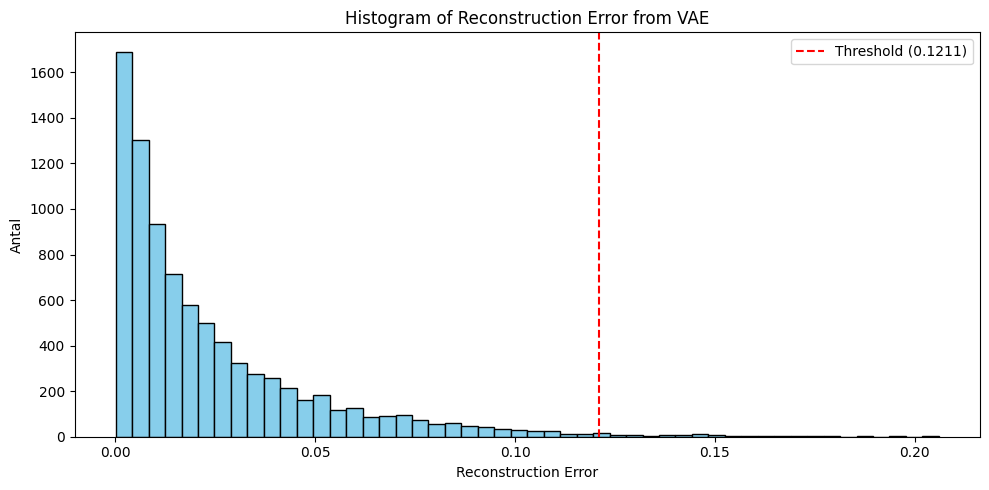

In [37]:
plt.figure(figsize=(10,5))
plt.hist(result_df["reconstruction_error"], bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title("Histogram of Reconstruction Error from VAE")
plt.xlabel("Reconstruction Error")
plt.ylabel("Antal")
plt.legend()
plt.tight_layout()
plt.show()


## Choosing epochs based on validation error on validation set (01-01-2018 - 01-01-2025)

Epoch 1/50 — Train Loss: 136.4051 — Val Loss: 60.0952
Epoch 2/50 — Train Loss: 47.1569 — Val Loss: 45.3708
Epoch 3/50 — Train Loss: 41.8670 — Val Loss: 49.7382
Epoch 4/50 — Train Loss: 42.3920 — Val Loss: 45.0705
Epoch 5/50 — Train Loss: 42.1663 — Val Loss: 28.8117
Epoch 6/50 — Train Loss: 41.8227 — Val Loss: 38.7920
Epoch 7/50 — Train Loss: 41.3326 — Val Loss: 43.0870
Epoch 8/50 — Train Loss: 40.0478 — Val Loss: 32.9719
Epoch 9/50 — Train Loss: 39.0390 — Val Loss: 30.3656
Epoch 10/50 — Train Loss: 39.2296 — Val Loss: 38.3681
Epoch 11/50 — Train Loss: 38.0192 — Val Loss: 31.2581
Epoch 12/50 — Train Loss: 37.9577 — Val Loss: 33.8001
Epoch 13/50 — Train Loss: 37.1147 — Val Loss: 37.3156
Epoch 14/50 — Train Loss: 35.6974 — Val Loss: 31.4605
Epoch 15/50 — Train Loss: 35.4889 — Val Loss: 29.1983
Early stopping triggered after 15 epochs


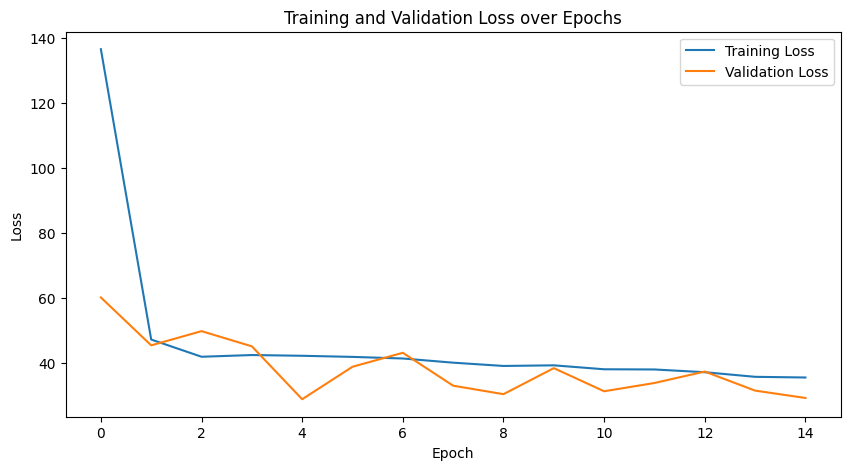

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


latent_dim = 2
beta = 0.1
hidden_dims = [64, 32]
batch_size = 32
epochs = 50
patience = 10 
learning_rate = 1e-4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], latent_dim=2):
        super().__init__()
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mean = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)
        decoder_layers = []
        hidden_dims_rev = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_rev:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mean(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def loss_fn(x, x_hat, mu, logvar, beta=1):
    recon = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return recon + beta * kl


dates = data3.loc[data3.dropna().index, "Date"].reset_index(drop=True)


split_date = pd.to_datetime("2018-01-01")

train_idx = dates < split_date
val_idx = dates >= split_date

X_train = X_tensor[train_idx.values]
X_val = X_tensor[val_idx.values]

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


model = VAE(input_dim=X_tensor.shape[1], hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

input_dim = X_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(input_dim=input_dim, hidden_dims=[64, 32], latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Lavere lr



best_val_loss = np.inf
epochs_no_improve = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x, x_hat, mu, logvar, beta=0.1)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x_val = batch[0].to(device)
            x_hat_val, mu_val, logvar_val = model(x_val)
            val_loss = loss_fn(x_val, x_hat_val, mu_val, logvar_val, beta=0.1)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_train_loss:.4f} — Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_vae_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

model.load_state_dict(torch.load("best_vae_model.pth"))

model.eval()
with torch.no_grad():
    X_recon, _, _ = model(X_tensor.to(device))
    rec_err = torch.mean((X_tensor.to(device) - X_recon) ** 2, dim=1).cpu().numpy()


plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


🎯 Overlap score: 6 (beta=0.1, latent_dim=2)


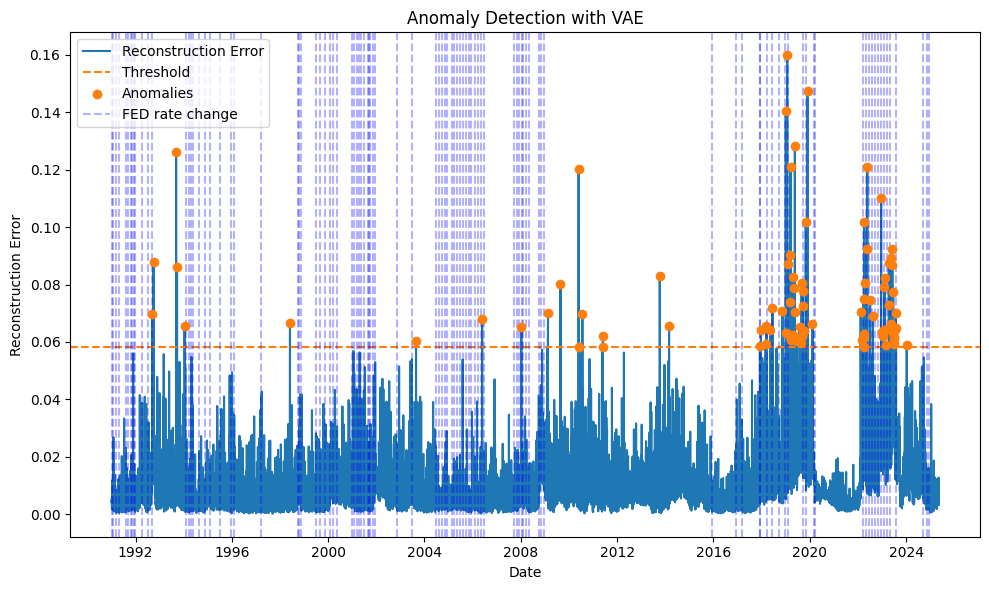

In [ ]:
threshold = np.percentile(rec_err, 99)
anomalies = rec_err > threshold


result_df = pd.DataFrame({
    "Date": data2.loc[data3.dropna().index, "Date"].reset_index(drop=True),
    "reconstruction_error": rec_err,
    "anomaly": anomalies
})


score = overlap_score(result_df, fed_change_dates, window_days=3)
print(f"\n🎯 Overlap score: {score} (beta={beta}, latent_dim={latent_dim})")

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
orange_color = default_colors[1] 

plt.figure(figsize=(10,6))
plt.plot(result_df["Date"], result_df["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color=orange_color, linestyle='--', label="Threshold")
plt.scatter(result_df[result_df["anomaly"]]["Date"],
            result_df[result_df["anomaly"]]["reconstruction_error"],
            color=orange_color, label="Anomalies", zorder=5)

first_line = True
for date in fed_change_dates:
    if date >= result_df["Date"].min():
        if first_line:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3, label="FED rate change")
            first_line = False
        else:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3)

plt.legend(loc="upper left")
plt.title("Anomaly Detection with VAE")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.show()



clearly generalizes best on the validation set (2018-2024) hence not good for finding anomalies in the whole timeframe